In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/yelp/yelp/filted_nv.csv')
train_index = df[df.date < '2019-06-30'].index
train_df = df.loc[train_index]

In [ ]:
categories = df.categories.unique()

In [ ]:
test_df = df.loc[test_index][(df.loc[test_index].user_id.isin(train_df.user_id.unique())) & (df.loc[test_index].business_id.isin(train_df.business_id.unique()))]

In [ ]:
test_user_matrix = users_items_matrix_df.loc[test_df.user_id.unique()]

In [ ]:
user_similarity = pairwise_distances(test_user_matrix, users_items_matrix_df, metric='cosine', force_all_finite=False)

In [ ]:
test_user_id = list(test_df.user_id.unique())
test_user_id_index = []
for i in range(len(users_items_matrix_df.index)):
  if users_items_matrix_df.index[i] in test_user_id:
    test_user_id_index.append(i)

In [ ]:
users_items_matrix = users_items_matrix_df.values
user_num = users_items_matrix.shape[0]

#### Hierachical Cluster

In [ ]:
df_business = pd.read_csv('/content/drive/MyDrive/yelp/business_train_features.csv',index_col = 'business_id')

In [ ]:
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler()
data = scaler.fit_transform(df_business)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster_metrics = {}
for NUM_CLUSTERS in range(10,100,2):
  clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(data)
  labels = clustering.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 10 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

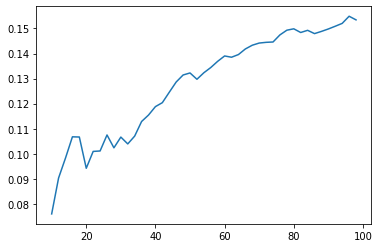

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(100,500,5):
  clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(data)
  labels = clustering.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 50 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

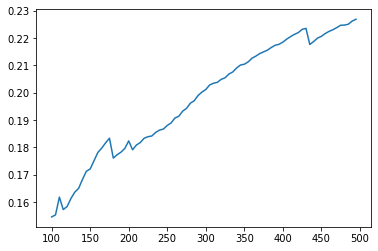

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(500,1000,5):
  clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(data)
  labels = clustering.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 50 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

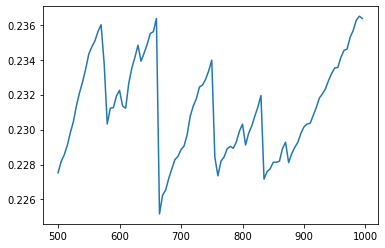

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(1000,1500,5):
  clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(data)
  labels = clustering.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 50 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

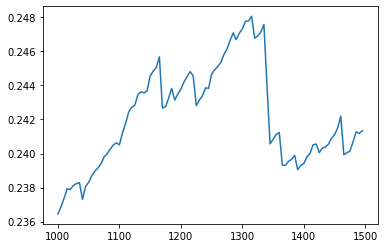

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(1500,2000,5):
  clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(data)
  labels = clustering.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 50 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

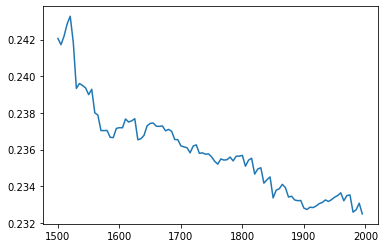

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
clustering = AgglomerativeClustering(n_clusters=1300).fit(data)
labels = clustering.labels_

In [ ]:
df_business['cluster_hierachic'] = labels

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=250, random_state=0).fit(data)
labels = kmeans.labels_

In [ ]:
df_business['cluster_kmeans'] = labels
df_business[['cluster_hierachic','cluster_kmeans']].to_csv('/content/drive/MyDrive/yelp/bus_cluster_km&hrc.csv')

## Predict with cluster

#### Hierachical Clustering

In [ ]:
df_bus_cluster = pd.read_csv('/content/drive/MyDrive/yelp/bus_cluster_km&hrc.csv')

In [ ]:
df_reviews_train = pd.read_csv('/content/drive/MyDrive/yelp/reviews_train.csv')
df_reviews_train = df_reviews_train[['user_id','business_id','stars_r','opinion_rating','overal_rating','useful_pred']]
df_reviews_train = df_reviews_train.merge(df_bus_cluster,on='business_id')

In [ ]:
users_items_star_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'cluster_hierachic', values = 'opinion_rating', aggfunc='mean')
users_items_star_df = users_items_star_df.fillna(0)

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# input
# input x
X = users_items_star_df.values
y = users_items_star_df.values

In [ ]:
# Build model
model = autoEncoder(X)
model.compile(optimizer = Adam(lr=0.0001), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 1300)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               666112    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 1300)              666900    
Total params: 1,595,924
Trainable params: 1,595,924
Non-trainable params: 0
___________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
hist = model.fit(x=X, y=y,
                  epochs=10,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1, callbacks=[es])
model.save('/content/drive/MyDrive/yelp/auto_encode_hrc_opinion')

Epoch 1/10
1300/1300 [==============================] - 41s 31ms/step - loss: 0.1279 - val_loss: 0.0284
Epoch 2/10
1300/1300 [==============================] - 40s 31ms/step - loss: 0.0314 - val_loss: 0.0259
Epoch 3/10
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0293 - val_loss: 0.0248
Epoch 4/10
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0285 - val_loss: 0.0241
Epoch 5/10
1300/1300 [==============================] - 41s 31ms/step - loss: 0.0279 - val_loss: 0.0237
Epoch 6/10
1300/1300 [==============================] - 40s 31ms/step - loss: 0.0273 - val_loss: 0.0234
Epoch 7/10
1300/1300 [==============================] - 41s 32ms/step - loss: 0.0273 - val_loss: 0.0233
Epoch 8/10
1300/1300 [==============================] - 38s 29ms/step - loss: 0.0270 - val_loss: 0.0231
Epoch 9/10
1300/1300 [==============================] - 40s 31ms/step - loss: 0.0268 - val_loss: 0.0230
Epoch 10/10
1300/1300 [==============================] - 40s 31m

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/yelp/auto_encode_hrc_opinion')

In [ ]:
new_matrix = model.predict(X) * (X == 0)

In [ ]:
new_users_items_star_df = pd.DataFrame(new_matrix, columns = users_items_star_df.columns, index = users_items_star_df.index)

In [ ]:
new_users_items_star_df = new_users_items_star_df + users_items_star_df
del model
del users_items_star_df

In [ ]:
def generate_business_info(test_df, new_users_items_matrix_df,users_items_useful_df):
  business_id_info = {}
  test_business_id = test_df.business_id.unique()
  for bus_id in test_business_id:
    current_business_rating = new_users_items_matrix_df[bus_id]
    current_business_useful = users_items_useful_df[bus_id]
    index = np.where(current_business_rating>=1)[0]
    current_rating = current_business_rating[index].values
    current_helpful = current_business_useful[index].values
    business_id_info[bus_id] = (index,current_rating,current_helpful)
  return business_id_info

def generate_user_id_index(test_user_matrix):
  test_user_id_index = {}
  for i in range(len(test_user_matrix.index)):
    test_user_id_index[test_user_matrix.index[i]] = i
  return test_user_id_index

In [ ]:
users_items_star_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'business_id', values = 'opinion_rating', aggfunc='mean')
users_items_useful_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'business_id', values = 'useful_pred', aggfunc='mean').fillna(-1)
business_id_info = generate_business_info(test_df, users_items_star_df,users_items_useful_df)

In [ ]:
# users_items_star_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars_r', aggfunc='mean')

In [ ]:
# users_items_useful_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'business_id', values = 'useful_pred', aggfunc='mean').fillna(-1)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/yelp/hierachic/test_with_prediction.csv')

In [ ]:
# business_id_info = generate_business_info(test_df, users_items_star_df,users_items_useful_df)

In [ ]:
# import pickle
# with open("/content/drive/MyDrive/yelp/hierachic/business_id_info_opinion.pkl", "wb") as f: 
#   pickle.dump(business_id_info, f)

In [ ]:
import pickle
with open("/content/drive/MyDrive/yelp/hierachic/business_id_info_opinion.pkl", "rb") as f:
  business_id_info = pickle.load(f)

In [ ]:
test_user_matrix = new_users_items_star_df.loc[test_df.user_id.unique()]

In [ ]:
user_similarity = pairwise_distances(test_user_matrix, new_users_items_star_df, metric='cosine')

In [ ]:
test_user_id_index = generate_user_id_index(test_user_matrix)
test_no_dup = test_df.groupby(['user_id','business_id']).mean().reset_index()

In [ ]:
test_no_dup.columns

Index(['user_id', 'business_id', 'stars_r', 'opinion_rating', 'overal_rating',
       'predict_rating_star', 'predict_rating_star_useful'],
      dtype='object')

In [ ]:
# baseline prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,50)
test_no_dup['predict_rating_star'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star)))

R2: 0.08660606227800294
RMSE: 1.4083251780502026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
# prediction with useful threhold
test_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,0.01,50)
test_no_dup['predict_rating_star_useful'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful)))

R2: 0.1204697719098754
RMSE: 1.3821264090737824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [ ]:
# baseline prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,50)
test_no_dup['predict_rating_opinion'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_opinion))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_opinion)))

R2: 0.08529141582973732
RMSE: 1.4095199545266037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
# prediction with useful threhold
test_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,0.01,50)
test_no_dup['predict_rating_opinion_useful'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_opinion_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_opinion_useful)))

R2: 0.11889008664528011
RMSE: 1.3833908374455135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [ ]:
test_no_dup['predict_rating_overall'] = (test_no_dup.predict_rating_opinion+test_no_dup.predict_rating_star)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall)))

R2: 0.09057633892191175
RMSE: 1.4054421554754633


In [ ]:
test_no_dup['predict_rating_overall_useful'] = (test_no_dup.predict_rating_opinion_useful+test_no_dup.predict_rating_star_useful)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful)))

R2: 0.12046337449152578
RMSE: 1.3821552115661375


#### Kmeans

In [ ]:
users_items_star_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'cluster_kmeans', values = 'opinion_rating', aggfunc='mean')
users_items_star_df = users_items_star_df.fillna(0)

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(150, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(75, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(150, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# input
# input x
X = users_items_star_df.values
y = users_items_star_df.values

In [ ]:
# Build model
model = autoEncoder(X)
model.compile(optimizer = Adam(lr=0.0001), loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 150)               37650     
_________________________________________________________________
LatentSpace (Dense)          (None, 75)                11325     
_________________________________________________________________
Dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 150)               11400     
_________________________________________________________________
UserScorePred (Dense)        (None, 250)               37750     
Total params: 98,125
Trainable params: 98,125
Non-trainable params: 0
_______________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
hist = model.fit(x=X, y=y,
                  epochs=10,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1, callbacks=[es])
model.save('/content/drive/MyDrive/yelp/kmeans/auto_encode_km_opinion')

Epoch 1/10
1300/1300 [==============================] - 6s 4ms/step - loss: 0.5084 - val_loss: 0.1392
Epoch 2/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1571 - val_loss: 0.1282
Epoch 3/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1424 - val_loss: 0.1224
Epoch 4/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1383 - val_loss: 0.1189
Epoch 5/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1345 - val_loss: 0.1165
Epoch 6/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1331 - val_loss: 0.1148
Epoch 7/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1327 - val_loss: 0.1138
Epoch 8/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1336 - val_loss: 0.1133
Epoch 9/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.1310 - val_loss: 0.1128
Epoch 10/10
1300/1300 [==============================] - 5s 4ms/step - loss: 0.131

In [ ]:
new_matrix = model.predict(X) * (X == 0)

In [ ]:
new_users_items_star_df = pd.DataFrame(new_matrix, columns = users_items_star_df.columns, index = users_items_star_df.index)

In [ ]:
new_users_items_star_df = new_users_items_star_df + users_items_star_df
del model
del users_items_star_df

In [ ]:
def generate_user_id_index(test_user_matrix):
  test_user_id_index = {}
  for i in range(len(test_user_matrix.index)):
    test_user_id_index[test_user_matrix.index[i]] = i
  return test_user_id_index

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/yelp/kmeans/test_with_prediction.csv')

In [ ]:
import pickle
with open("/content/drive/MyDrive/yelp/hierachic/business_id_info_opinion.pkl", "rb") as f:
  business_id_info = pickle.load(f)

In [ ]:
test_user_matrix = new_users_items_star_df.loc[test_df.user_id.unique()]

In [ ]:
user_similarity = pairwise_distances(test_user_matrix, new_users_items_star_df, metric='cosine')

In [ ]:
test_user_id_index = generate_user_id_index(test_user_matrix)
test_no_dup = test_df.groupby(['user_id','business_id']).mean().reset_index()

In [ ]:
def predict_rating_helpful_cf(test_df,business_id_info,user_similarity,test_user_id_index,helpful_threhold,num_sim):
  test_user_bus = test_df.to_dict('split')['data']
  test_ratings = []
  for i in test_user_bus:
    user_index = test_user_id_index[i[0]]
    current_sim = user_similarity[user_index][business_id_info[i[1]][0]]
    current_helpful = business_id_info[i[1]][2]
    selected_index = np.where(current_helpful>=helpful_threhold)[0]
    current_rating_list = business_id_info[i[1]][1]
    if selected_index.shape[0]>0:
      current_sim = current_sim[selected_index]
      current_rating = current_rating_list[selected_index]
    selected_index = np.argsort(current_sim)[-num_sim:]
    current_sim = current_sim[selected_index]
    current_rating_list = current_rating_list[selected_index]
    current_rating = (current_sim * current_rating_list).sum()/current_sim.sum()
    test_ratings.append(current_rating)
  return test_ratings

In [ ]:
def predict_rating_cf(test_df,business_id_info,user_similarity,test_user_id_index,num_sim):
  test_user_bus = test_df.to_dict('split')['data']
  test_ratings = []
  for i in test_user_bus:
    user_index = test_user_id_index[i[0]]
    current_sim = user_similarity[user_index][business_id_info[i[1]][0]]
    selected_index = np.argsort(current_sim)[-num_sim:]
    current_sim = current_sim[selected_index]
    current_rating = (current_sim * business_id_info[i[1]][1][selected_index]).sum()/(current_sim).sum()
    test_ratings.append(current_rating)
  return test_ratings

In [ ]:
# baseline prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,50)
test_no_dup['predict_rating_star'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star)))

R2: 0.07623320508167031
RMSE: 1.4164575185954151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
# prediction with useful threhold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,0.01,50)
test_no_dup['predict_rating_star_useful'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful)))

R2: 0.12471912031210508
RMSE: 1.3787835747438368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [ ]:
# prediction with sentiment score
test_no_dup['predict_rating_overall'] = (test_no_dup.predict_rating_opinion+test_no_dup.predict_rating_star)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall)))

R2: 0.09011061042291324
RMSE: 1.4057777999411458


In [ ]:
# prediction with sentiment score and useful threhold
test_no_dup['predict_rating_overall_useful'] = (test_no_dup.predict_rating_opinion_useful+test_no_dup.predict_rating_star_useful)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful)))

R2: 0.13856619825494587
RMSE: 1.3678338114078046
